In [163]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from faker import Faker

# Configure visualization libraries for better visuals
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [128]:
import mysql.connector

def connect_to_db(user='root', password='root', host='localhost', database='ecommerce'):
    try:
        # Attempt to connect to the database
        connection = mysql.connector.connect(
            user=user,
            password=password,
            host=host,
            database=database
        )
        print(f"Connected to the database '{database}' successfully.")
        return connection

    except mysql.connector.Error as err:
        # Handle database not found error
        if err.errno == 1049:  # Error code for "Unknown database"
            print(f"Database '{database}' not found. Creating a new one.")
            try:
                # Connect to MySQL without specifying a database to create one
                connection = mysql.connector.connect(
                    user=user,
                    password=password,
                    host=host
                )
                cursor = connection.cursor()
                cursor.execute(f"CREATE DATABASE {database}")
                cursor.close()
                connection.close()
                print(f"Database '{database}' created successfully.")
                
                # Connect to the newly created database
                connection = mysql.connector.connect(
                    user=user,
                    password=password,
                    host=host,
                    database=database
                )
                print(f"Connected to the new database '{database}' successfully.")
                return connection

            except mysql.connector.Error as err:
                print(f"Failed to create database '{database}': {err}")
                return None
        else:
            print(f"Error: {err}")
            return None

# Establish the connection
connection = connect_to_db()


Connected to the database 'ecommerce' successfully.


In [108]:
def create_tables(connection):
    cursor = connection.cursor()
    cursor.execute("SET SESSION lock_wait_timeout = 300")

    # Create customer table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS `customer` (
        `customer_id` varchar(10) NOT NULL,
        `name` varchar(100) NOT NULL,
        `city` varchar(65) NOT NULL,
        `email` varchar(45) NOT NULL,
        `phone_no` varchar(15) NOT NULL,
        `address` varchar(100) NOT NULL,
        `pin_code` int NOT NULL,
        PRIMARY KEY (`customer_id`)
    );
    """)

    # Create product table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS `product` (
        `product_id` varchar(10) NOT NULL,
        `product_name` varchar(100) NOT NULL,
        `category` varchar(65) NOT NULL,
        `sub_category` varchar(45) NOT NULL,
        `original_price` double NOT NULL,
        `stock` int NOT NULL,
        PRIMARY KEY (`product_id`)
    );
    """)

    # Create order_details table
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS `order_details` (
        `order_id` int NOT NULL AUTO_INCREMENT,
        `customer_id` varchar(10) NOT NULL,
        `product_id` varchar(10) NOT NULL,
        `quantity` double NOT NULL,
        `total_price` double NOT NULL,
        `payment_mode` varchar(60) NOT NULL,
        `order_date` datetime DEFAULT NULL,
        `order_status` varchar(20) NOT NULL,
        PRIMARY KEY (`order_id`),
        KEY `customer_id` (`customer_id`),
        KEY `product_id` (`product_id`),
        CONSTRAINT `order_details_ibfk_1` FOREIGN KEY (`customer_id`)
        REFERENCES `customer` (`customer_id`),
        CONSTRAINT `order_details_ibfk_2` FOREIGN KEY (`product_id`)
        REFERENCES `product` (`product_id`)
    );
    """)
    
    cursor.close()
    print("Tables Created")

create_tables(connection)

Tables Created


In [116]:
def insert_data(connection):
    cursor = connection.cursor()

    # Insert data into customer table
    customer_data = []
    customer_ids = set()
    for _ in range(50):
        while True:
            customer_id = str(fake.unique.random_int(min=1000, max=9999))
            if customer_id not in customer_ids:
                customer_ids.add(customer_id)
                break
        name = fake.name()
        city = fake.city()
        email = fake.email()
        phone_no = fake.phone_number()[:15]
        address = fake.address().replace('\n', ', ')
        pin_code = fake.random_int(min=100000, max=999999)

        customer_data.append((customer_id, name, city, email, phone_no, address, pin_code))

    cursor.executemany("""
    INSERT INTO customer (customer_id, name, city, email, phone_no, address, pin_code)
    VALUES (%s, %s, %s, %s, %s, %s, %s);
    """, customer_data)
    connection.commit()
    print("Inserted data into customer table.")

    # Insert data into product table
    categories = ['Electronics', 'Fashion', 'Home & Kitchen', 'Books', 'Toys']
    sub_categories = {
        'Electronics': ['Mobiles', 'Laptops', 'Cameras'],
        'Fashion': ['Men', 'Women', 'Kids'],
        'Home & Kitchen': ['Furniture', 'Appliances', 'Decor'],
        'Books': ['Fiction', 'Non-Fiction', 'Educational'],
        'Toys': ['Action Figures', 'Board Games', 'Puzzles']
    }

    product_data = []
    product_ids = set()
    for _ in range(50):
        while True:
            product_id = str(fake.unique.random_int(min=1000, max=9999))
            if product_id not in product_ids:
                product_ids.add(product_id)
                break
        product_name = fake.word().capitalize()
        category = random.choice(categories)
        sub_category = random.choice(sub_categories[category])
        original_price = round(fake.random_number(digits=4, fix_len=True) / 100, 2)
        stock = fake.random_int(min=10, max=100)

        product_data.append((product_id, product_name, category, sub_category, original_price, stock))

    try:
        cursor.executemany("""
        INSERT INTO product (product_id, product_name, category, sub_category, original_price, stock)
        VALUES (%s, %s, %s, %s, %s, %s);
        """, product_data)
        connection.commit()
        print("Inserted data into product table.")
    except mysql.connector.IntegrityError as e:
        print(f"IntegrityError during product data insertion: {e}")

    # Insert data into order_details table
    order_data = []
    for _ in range(50):
        customer_id = random.choice(list(customer_ids))
        product_id = random.choice(list(product_ids))
        quantity = fake.random_int(min=1, max=5)
        total_price = round(quantity * fake.random_number(digits=4, fix_len=True) / 100, 2)
        payment_mode = random.choice(['Credit Card', 'Debit Card', 'Cash on Delivery', 'Net Banking'])
        order_date = fake.date_time_this_year()
        order_status = random.choice(['Pending', 'Shipped', 'Delivered', 'Cancelled'])

        order_data.append((customer_id, product_id, quantity, total_price, payment_mode, order_date, order_status))

    try:
        cursor.executemany("""
        INSERT INTO order_details (customer_id, product_id, quantity, total_price, payment_mode, order_date, order_status)
        VALUES (%s, %s, %s, %s, %s, %s, %s);
        """, order_data)
        connection.commit()
        print("Inserted data into order_details table.")
    except mysql.connector.IntegrityError as e:
        print(f"IntegrityError during order data insertion: {e}")

    cursor.close()


insert_data(connection)

Inserted data into customer table.
Inserted data into product table.
Inserted data into order_details table.


In [132]:
def fetch_data(query, connection):
    try:
        return pd.read_sql(query, connection)
    except Exception as e:
        print(f"An error occurred: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of an error

# Connect to the database
connection = connect_to_db()

if connection:
    # Fetching data with SQL queries
    customer_data = fetch_data('SELECT * FROM customer', connection)
    product_data = fetch_data('SELECT * FROM product', connection)
    order_data = fetch_data('SELECT * FROM order_details', connection)
    
    # Print fetched data
    print("Customer Data:")
    print(customer_data.head())
    print("\nProduct Data:")
    print(product_data.head())
    print("\nOrder Data:")
    print(order_data.head())

Connected to the database 'ecommerce' successfully.
Customer Data:
  customer_id              name               city                     email  \
0        1082    Crystal Rivera   North Haleymouth        sara87@example.org   
1        1185  Timothy Browning   Lake Danielburgh  danielrangel@example.org   
2        1197     Sarah Jackson  South Rhondahaven   catherine09@example.net   
3        1206       Tim Goodman          Carlaside     richard06@example.net   
4        1212  Melanie Anderson     East Nathaniel  davidspencer@example.net   

          phone_no                                            address  \
0  (814)291-4679x2  01542 Taylor Points Suite 607, Clarkland, IN 3...   
1  667-563-0911x51                   PSC 5916, Box 8559, APO AA 80909   
2  748-389-3611x24           24482 Gill Island, Lake Stacey, KY 39397   
3  001-311-984-804   84485 Gary Meadow Suite 028, Jaredstad, MH 13311   
4  541.350.9862x70           207 Lin Junction, Lake Charles, GU 68338   

   pin_code  

C:\Users\HP\AppData\Local\Temp\ipykernel_26500\937031273.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql(query, connection)


In [134]:
## Cleaning of Data
# Checking for missing values
print(customer_data.isnull().sum())
print(product_data.isnull().sum())
print(order_data.isnull().sum())

# Converting data types if necessary
# For example, if the order_date is not in datetime format:
order_data['order_date'] = pd.to_datetime(order_data['order_date'])

C:\Users\HP\AppData\Local\Temp\ipykernel_26500\1151966455.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


EDA

city
Taylorville           2
North Haleymouth      1
North Nicolefort      1
Lynntown              1
West Kendraborough    1
                     ..
Chanland              1
Jennaville            1
North Robinmouth      1
Lake Andrea           1
Sarahaven             1
Name: count, Length: 199, dtype: int64


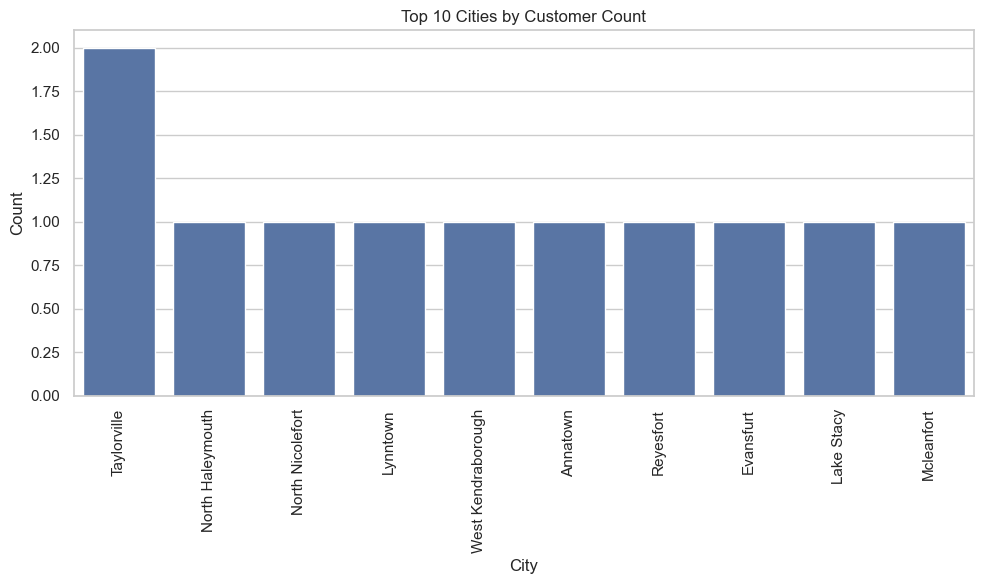

customer_id
9949    4
5409    4
8539    4
5895    3
6708    3
1701    3
5504    3
2629    3
9287    3
5012    2
Name: count, dtype: int64


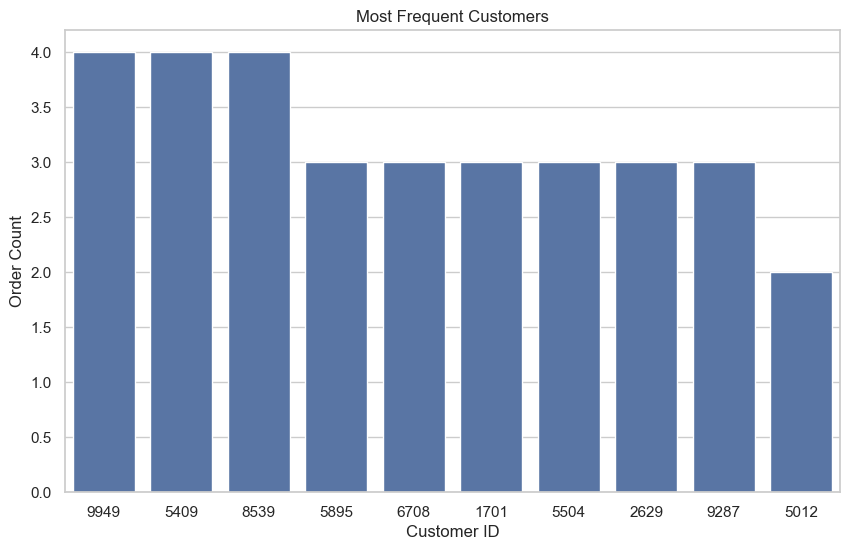

In [165]:
# Customer Analysis
customer_citywise = customer_data['city'].value_counts()
print(customer_citywise)
# Top 10 cities by customer count
top_10_cities = customer_citywise.nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_cities.index, y=top_10_cities.values)
plt.title("Top 10 Cities by Customer Count")
plt.xlabel("City")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

frequent_customers = order_data['customer_id'].value_counts().head(10)
print(frequent_customers)
plt.figure(figsize=(10, 6))
sns.barplot(x=frequent_customers.index, y=frequent_customers.values)
plt.title("Most Frequent Customers")
plt.xlabel("Customer ID")
plt.ylabel("Order Count")
plt.show()

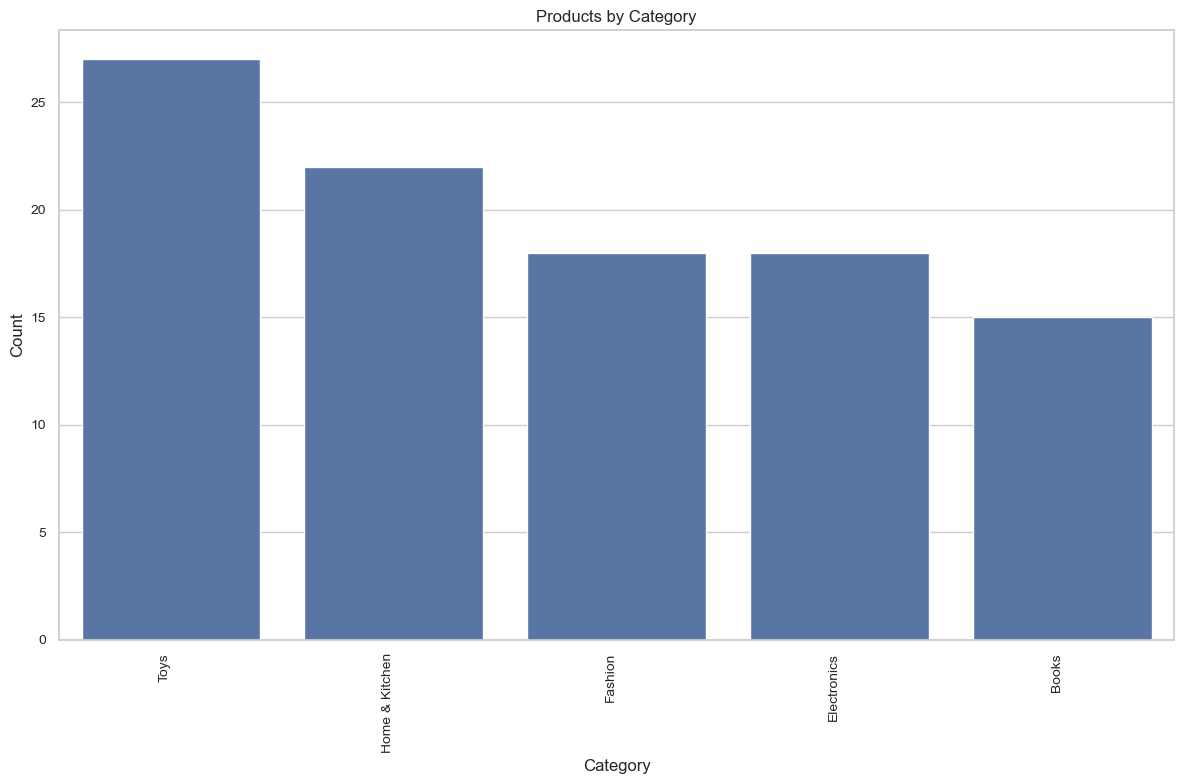

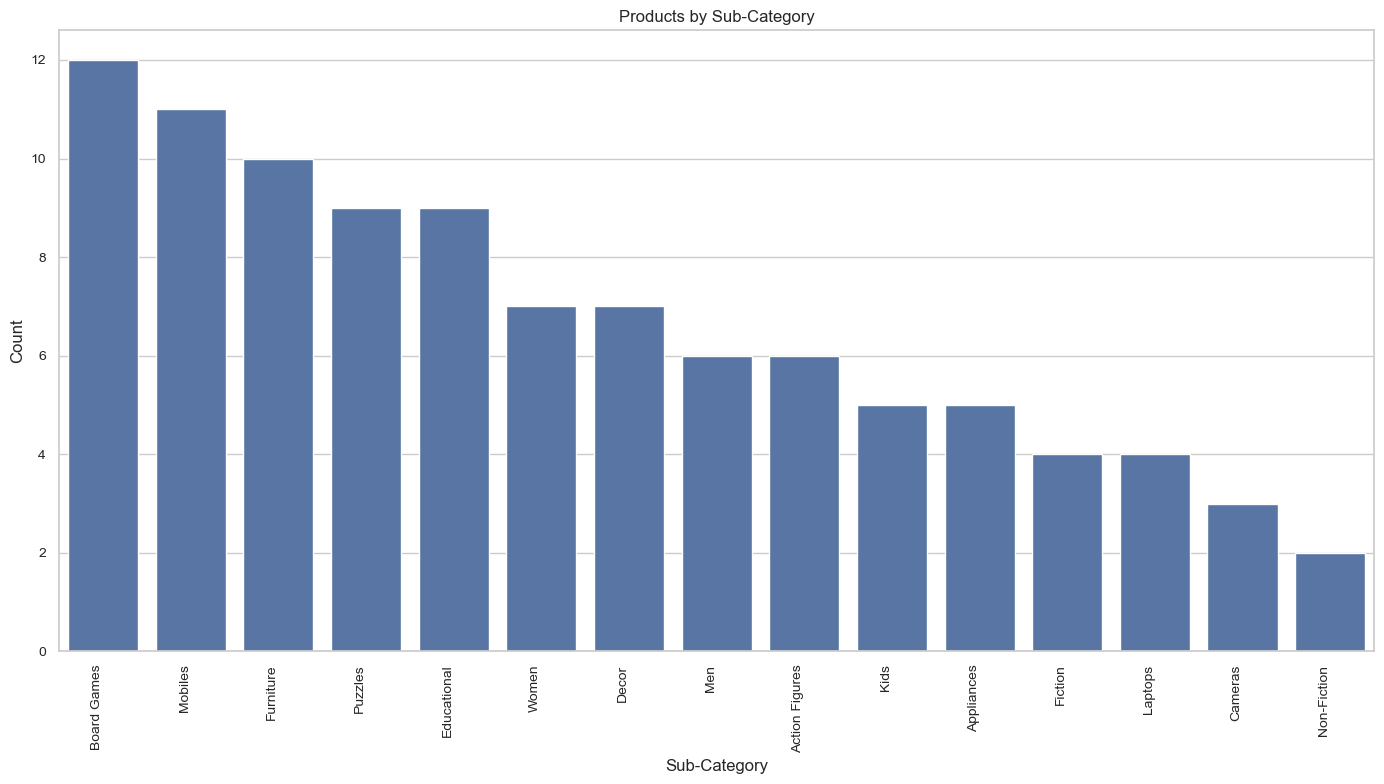

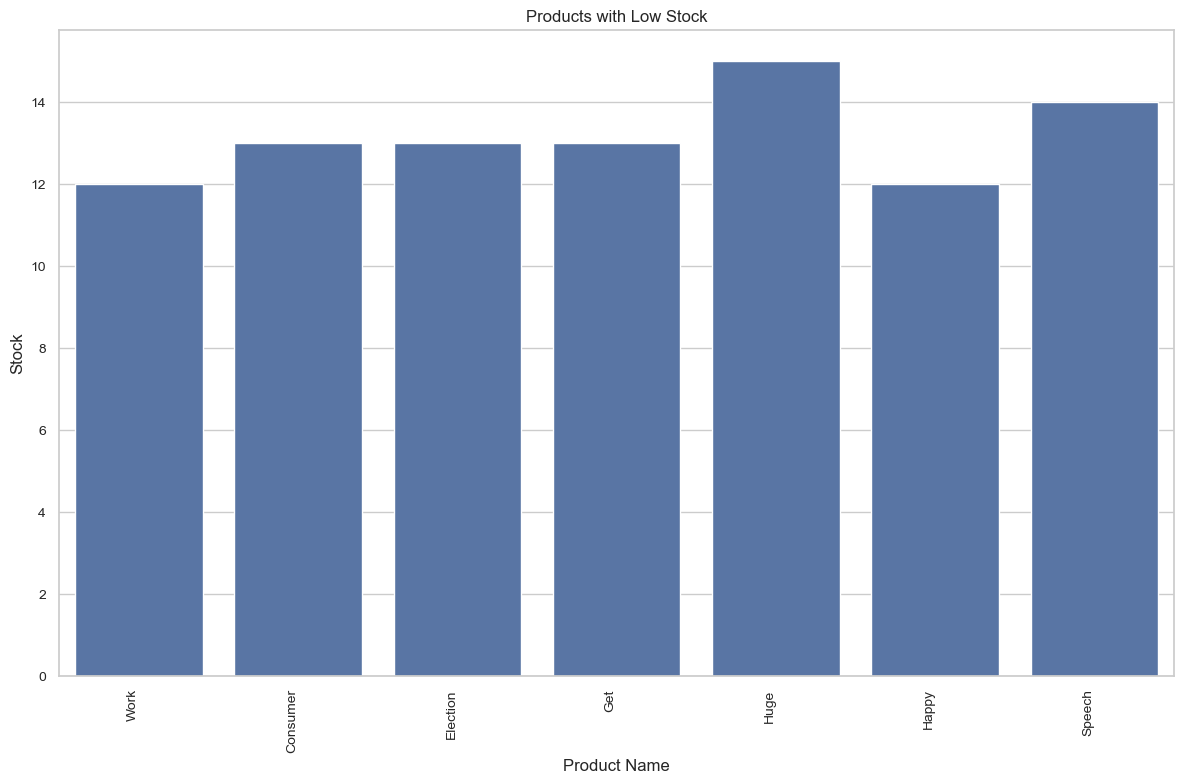

mean    52.6938
max     99.7800
min     10.2500
Name: original_price, dtype: float64


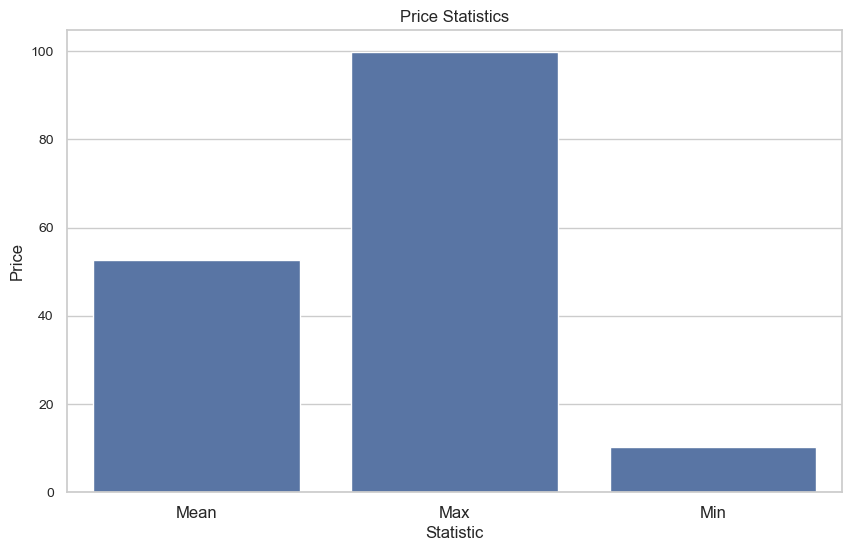

   product_id product_name        category    sub_category  original_price  \
25       3729         Work            Toys  Action Figures           98.76   
64       7221     Consumer           Books     Non-Fiction           80.46   
69       7637     Election            Toys     Board Games           10.28   
79       8415          Get         Fashion            Kids           66.06   
82       8834         Huge         Fashion           Women           28.21   
95       9626        Happy  Home & Kitchen       Furniture           21.07   
99       9988       Speech     Electronics         Laptops           38.32   

    stock  
25     12  
64     13  
69     13  
79     13  
82     15  
95     12  
99     14  


In [200]:
# Product Analysis
# Products by Category
plt.figure(figsize=(12, 8))
sns.barplot(x=products_by_category.index, y=products_by_category.values)
plt.title("Products by Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Products by Sub-Category
plt.figure(figsize=(14, 8))
sns.barplot(x=products_by_subcategory.index, y=products_by_subcategory.values)
plt.title("Products by Sub-Category")
plt.xlabel("Sub-Category")
plt.ylabel("Count")
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Products with Low Stock
low_stock_products = product_data[product_data['stock'] <= 15]
plt.figure(figsize=(12, 8))
sns.barplot(x=low_stock_products['product_name'], y=low_stock_products['stock'])
plt.title("Products with Low Stock")
plt.xlabel("Product Name")
plt.ylabel("Stock")
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Price Statistics
price_stats = product_data['original_price'].agg(['mean', 'max', 'min'])
print(price_stats)
plt.figure(figsize=(10, 6))
sns.barplot(x=['Mean', 'Max', 'Min'], y=[price_stats['mean'], price_stats['max'], price_stats['min']])
plt.title("Price Statistics")
plt.xlabel("Statistic")
plt.ylabel("Price")
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.show()

print(low_stock_products)

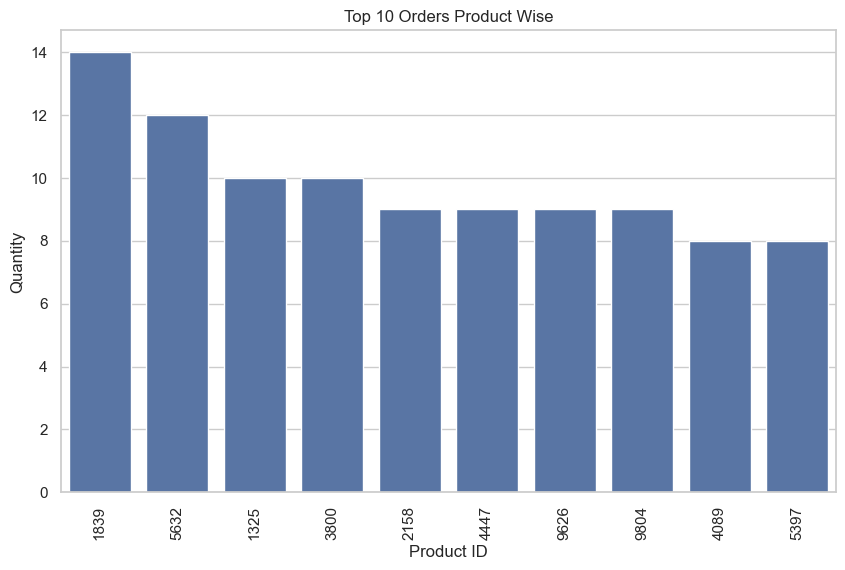

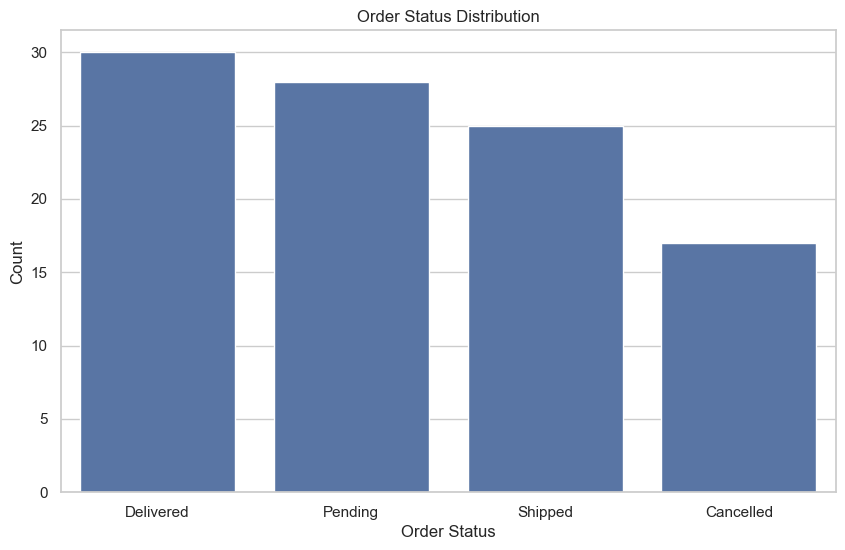

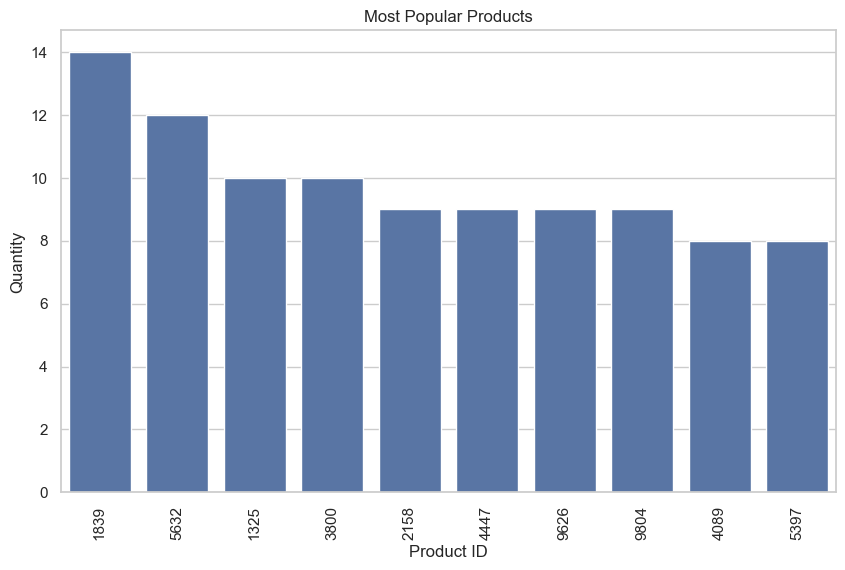

In [175]:
# Order Analysis

# Top 10 Orders Product Wise
top_orders = order_data.groupby('product_id')['quantity'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_orders.index, y=top_orders.values)
plt.title("Top 10 Orders Product Wise")
plt.xlabel("Product ID")
plt.ylabel("Quantity")
plt.xticks(rotation=90)
plt.show()

# Order Status Distribution
order_status_distribution = order_data['order_status'].value_counts()
plt.figure(figsize=(10, 6))
sns.barplot(x=order_status_distribution.index, y=order_status_distribution.values)
plt.title("Order Status Distribution")
plt.xlabel("Order Status")
plt.ylabel("Count")
plt.show()

# Most Popular Products
popular_products = order_data.groupby('product_id')['quantity'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=popular_products.index, y=popular_products.values)
plt.title("Most Popular Products")
plt.xlabel("Product ID")
plt.ylabel("Quantity")
plt.xticks(rotation=90)
plt.show()

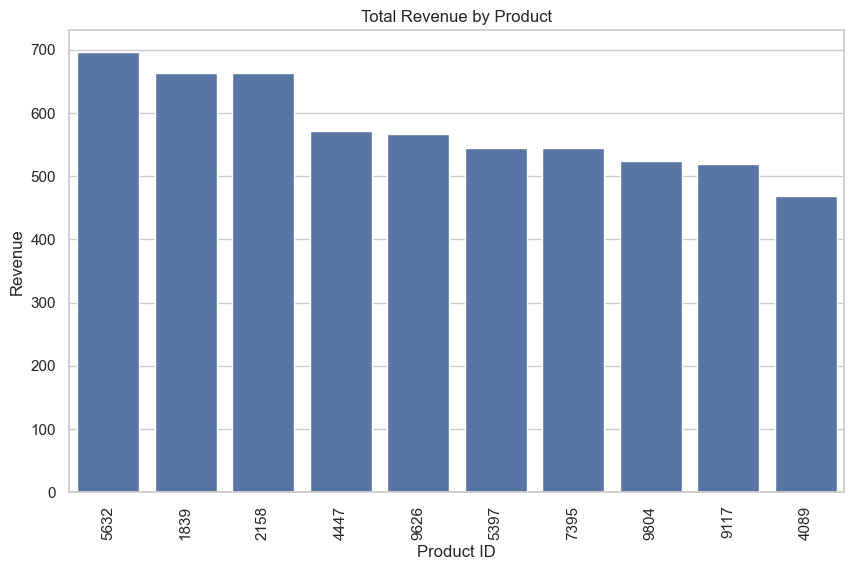

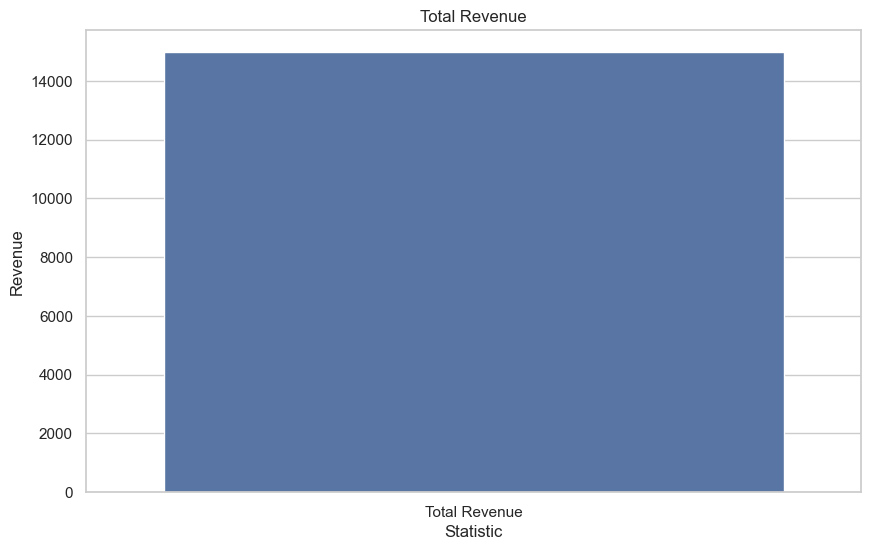

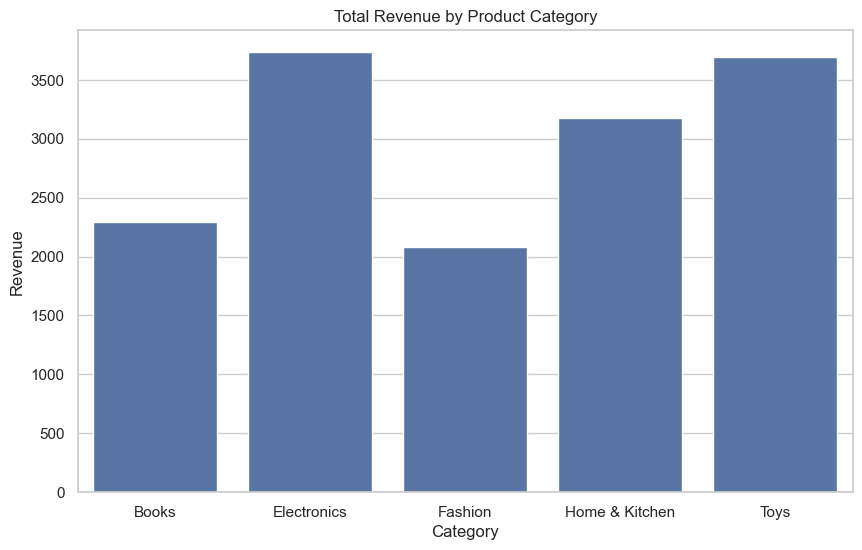

In [184]:
# Sales Analysis

# Total Revenue by Product
product_revenue = order_data.groupby('product_id')['total_price'].sum().nlargest(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=product_revenue.index, y=product_revenue.values)
plt.title("Total Revenue by Product")
plt.xlabel("Product ID")
plt.ylabel("Revenue")
plt.xticks(rotation=90)
plt.show()

# Total Revenue
total_revenue = order_data['total_price'].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=['Total Revenue'], y=[total_revenue])
plt.title("Total Revenue")
plt.xlabel("Statistic")
plt.ylabel("Revenue")
plt.show()

# Total Revenue by Product Category
product_category_revenue = order_data.merge(product_data, on='product_id').groupby('category')['total_price'].sum()
plt.figure(figsize=(10, 6))
sns.barplot(x=product_category_revenue.index, y=product_category_revenue.values)
plt.title("Total Revenue by Product Category")
plt.xlabel("Category")
plt.ylabel("Revenue")
plt.show()

